# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

## Loading the Data :
* We will use the SQLite File to load the dataset as it is easy to process
* We will ignore all rows where the score is 3 as we wont be able to give it a postive or negative class.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
%matplotlib inline

In [2]:
# Loading the table using sqlite
con = sqlite3.connect('database.sqlite')

In [3]:
# Taking only +ve and -ve reviews :
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)

In [4]:
# Giving postive rating to a review if score > 3 else negative rating
def posneg(x):
    if x > 3:
        return "positive"
    else:
        return "negative"

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(posneg)
filtered_data['Score'] = positiveNegative

print ("Shape of the Dataset -> ", filtered_data.shape)
print ("***************************************************\n")

filtered_data.head(3)

Shape of the Dataset ->  (525814, 10)
***************************************************



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# Exploratory Data Analysis :

In [5]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
Id                        525814 non-null int64
ProductId                 525814 non-null object
UserId                    525814 non-null object
ProfileName               525814 non-null object
HelpfulnessNumerator      525814 non-null int64
HelpfulnessDenominator    525814 non-null int64
Score                     525814 non-null object
Time                      525814 non-null int64
Summary                   525814 non-null object
Text                      525814 non-null object
dtypes: int64(4), object(6)
memory usage: 40.1+ MB


### Checking for Duplications :

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


> As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

> It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

> The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [7]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [13]:
# Picking out a Sample to work on.
pos1k = final[final['Score'] == "positive"]
pos1k = pos1k[:2000]

In [14]:
neg1k = final[final['Score'] == "negative"]
neg1k = neg1k[:2000]

In [15]:
# Mergin both dataframes ->
pos1k = pos1k.append(neg1k, ignore_index=True)
from sklearn.utils import shuffle
pos1k = shuffle(pos1k)

In [16]:
pos1k['Score'].value_counts()

negative    2000
positive    2000
Name: Score, dtype: int64

In [17]:
final = pos1k
print (final.shape)
print ("**********************************************************************")
final.head()

(4000, 10)
**********************************************************************


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2537,49116,B0000D94OW,A2QWNAQVM0CQX8,B. Petereson,2,2,negative,1249776000,Not that good,I was very happy to see a suger free option fo...
3920,525226,B0001UZLE4,A1Z3JECPQUO6PU,Christine Bichai,1,1,negative,1330560000,total rip off! missing products!,Was excited to get this for my husband's birth...
1556,197352,B000084F1I,A1UR339OJOBBHI,Qina,23,23,positive,1297209600,Great Chow,We moved to another state and could not find B...
737,149842,B00004S1C6,AZ0ZI2LVPAZQU,"J. Arentsen ""adjuster9""",0,4,positive,1339891200,Need More Info,Would love to try this after the rave reviews....
306,374371,B00004CI84,A1IZ6HFRXMIYOE,Zachary C. Heeren,0,1,positive,1271030400,Great Movie,This is an all-around great movie from the 90'...


## Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>


In [18]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [19]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

In [20]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

In [21]:
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [22]:
print(stop)

{'so', "couldn't", 'through', "don't", 'ain', 'theirs', 'don', 'he', 'on', 'shouldn', 'herself', 'a', 'ma', 'after', 'against', 'few', 's', 'out', 'each', 'over', 'below', 'will', 'mustn', 'have', 'which', 'can', "shan't", 'only', 've', "hasn't", "shouldn't", 'they', 'the', 'this', 'during', 'more', 'themselves', 'above', 'am', 'because', 'ourselves', 'what', 'here', 't', 'we', 'isn', 'into', 'once', "aren't", 'until', 'those', 'of', 'between', "you'll", 'there', 'no', 're', 'very', 'myself', 'in', 'same', 'why', 'should', 'his', 'does', 'other', "it's", 'and', 'did', 'their', 'while', 'off', 'i', 'him', "that'll", 'were', 'y', 'up', "she's", 'that', 'won', "wasn't", 'aren', 'own', 'o', 'by', 'than', "hadn't", 'with', 'from', 'most', 'do', 'had', 'your', 'was', 'm', 'having', 'is', 'if', 'hadn', 'at', 'how', 'it', 'didn', 'yours', 'these', 'hasn', 'weren', 'nor', 'an', 'needn', 'to', 'my', "you'd", 'whom', "should've", 'are', 'being', "you've", 'itself', 'yourself', 'but', 'has', 'hers

In [23]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)
    i+=1

In [24]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
2537,49116,B0000D94OW,A2QWNAQVM0CQX8,B. Petereson,2,2,negative,1249776000,Not that good,I was very happy to see a suger free option fo...,b'happi see suger free option cake disappoint ...
3920,525226,B0001UZLE4,A1Z3JECPQUO6PU,Christine Bichai,1,1,negative,1330560000,total rip off! missing products!,Was excited to get this for my husband's birth...,b'excit get husband birthday gift set total ri...
1556,197352,B000084F1I,A1UR339OJOBBHI,Qina,23,23,positive,1297209600,Great Chow,We moved to another state and could not find B...,b'move anoth state could find blue seal dog fo...


## Bag of Words Model :

In [25]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['Text'].values)

In [26]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [27]:
final_counts.get_shape()

(4000, 15220)

In [28]:
bogdata = pd.SparseDataFrame(final_counts)

In [29]:
bogdata = bogdata.fillna(0)

In [30]:
labels = final['Score']

In [31]:
from sklearn.manifold import TSNE

In [32]:
model = TSNE()

In [33]:
arr = bogdata.values

In [34]:
tsne_data = model.fit_transform(arr)

In [35]:
tsne_data = np.hstack((tsne_data, labels.values.reshape(-1,1)))

In [36]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim1", "Dim2", "Labels"))
tsne_df.head(2)

,Dim1,Dim2,Labels
0,-13.6839,11.4981,negative
1,9.46669,10.6549,negative


Text(0.5,1,'TSNE Plot with Bag of Words')

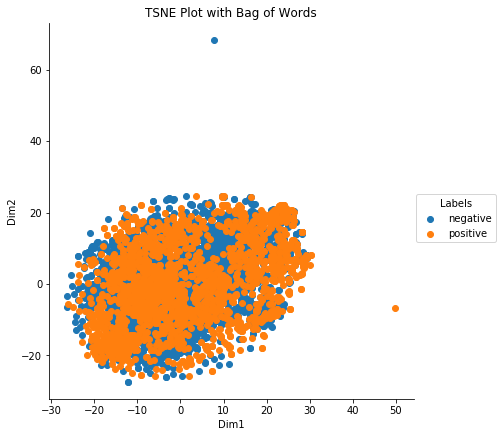

In [37]:
sns.FacetGrid(tsne_df, hue="Labels", size=6).map(plt.scatter, "Dim1", "Dim2").add_legend()
plt.title("TSNE Plot with Bag of Words")

## TF-IDF :

In [38]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['Text'].values)

In [39]:
final_tf_idf.get_shape()

(4000, 158520)

In [40]:
arr = final_tf_idf[:,:].toarray()
arr.shape

(4000, 158520)

In [ ]:
model = TSNE()

In [ ]:
tsne_data = model.fit_transform(arr)

In [ ]:
tsne_data = np.hstack((tsne_data, labels.values.reshape(-1,1)))
tsne_data.shape

In [ ]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim1", "Dim2", "Labels"))
tsne_df.head(2)

In [ ]:
sns.FacetGrid(tsne_df, hue="Labels", size=6).map(plt.scatter, "Dim1", "Dim2").add_legend()
plt.title("TSNE plot with TFIDF")

## Word2Vec :

In [ ]:
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [ ]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

## Avg W2V :

In [ ]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [ ]:
arr = np.array(sent_vectors)
arr.shape

In [ ]:
model = TSNE()

In [ ]:
tsne_data = model.fit_transform(arr)

In [ ]:
tsne_data = np.hstack((tsne_data, labels.values.reshape(-1,1)))
tsne_data.shape

In [ ]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim1", "Dim2", "Labels"))
tsne_df.head(2)

In [ ]:
sns.FacetGrid(tsne_df, hue="Labels", size=6).map(plt.scatter, "Dim1", "Dim2").add_legend()
plt.title("TSNE with Avg Word2Vec")

## TF-IDF W2V :

In [ ]:
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [ ]:
arr = np.array(tfidf_sent_vectors)
arr.shape

In [ ]:
model = TSNE()

In [ ]:
nanindexes = np.isnan(arr)
arr[nanindexes] = 0
tsne_data = model.fit_transform(arr)

In [ ]:
tsne_data = np.hstack((tsne_data, labels.values.reshape(-1,1)))
tsne_data.shape

In [ ]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim1", "Dim2", "Labels"))
tsne_df.head(2)

In [ ]:
sns.FacetGrid(tsne_df, hue="Labels", size=6).map(plt.scatter, "Dim1", "Dim2").add_legend()
plt.title("TSNE with TFIDF - weighted Word2Vec")